Running GridSearch for Logistic Regression...
Running GridSearch for Decision Tree...
Running GridSearch for Random Forest...
Running GridSearch for SVM...
Running RandomSearch for Logistic Regression...
Running RandomSearch for Decision Tree...
Running RandomSearch for Random Forest...
Running RandomSearch for SVM...

--- HYPERPARAMETER TUNING RESULTS COMPARISON ---
Method               GridSearch  RandomSearch
Model                                        
Decision Tree            0.7830        0.7830
Logistic Regression      0.9578        0.9589
Random Forest            0.9416        0.9372
SVM                      0.9600        0.9583

--- BEST OVERALL MODEL: SVM (GridSearch) ---
AUC: 0.9600, Accuracy: 0.8852
Parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verb

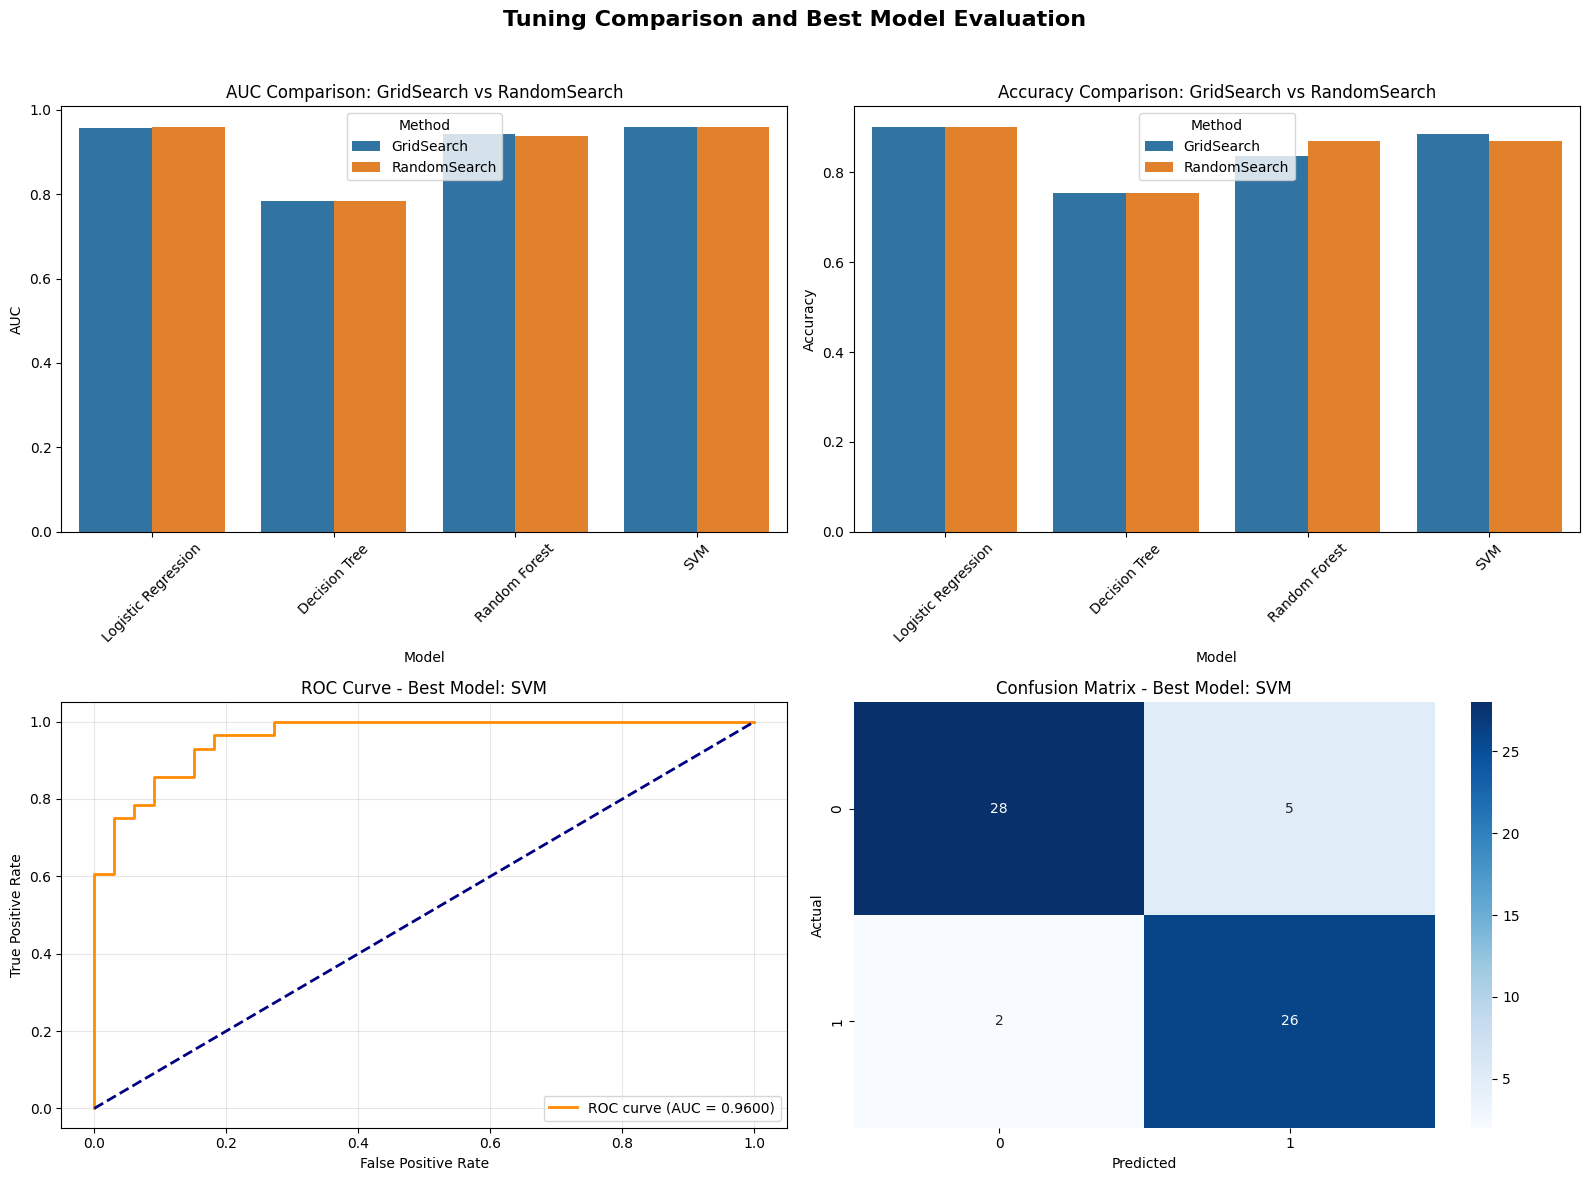

Final pipeline (scaler + SVM) saved to ../models\final_model.pkl
Comparison results saved to ../data/hyperparameter_tuning_comparison.csv

--- Reproducibility Check ---
Reloaded Pipeline Accuracy: 0.8688524590163934
Reloaded Pipeline AUC: 0.9583333333333333


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


file_path = '../data/heart_disease_selected_features.csv'
df = pd.read_csv(file_path)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}


param_configs = {
    'GridSearch': {
        'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']},
        'Decision Tree': {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]},
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [5, 7, 10]},
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'RandomSearch': {
        'Logistic Regression': {'C': np.logspace(-2, 2, 20), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']},
        'Decision Tree': {'max_depth': [3, 5, 7, 10, 15, None], 'min_samples_split': np.arange(2, 21)},
        'Random Forest': {'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 5, 10, None], 'max_features': ['sqrt', 'log2', 0.5]},
        'SVM': {'C': np.logspace(-1, 2, 15), 'kernel': ['linear', 'rbf'], 'gamma': np.logspace(-3, 1, 15)}
    }
}


def run_tuning(model, params, search_type, X_train, y_train):
    """Runs GridSearchCV or RandomizedSearchCV and returns the fitted search object."""
    if search_type == 'GridSearch':
        searcher = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    else:  # RandomizedSearch
        searcher = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    
    searcher.fit(X_train, y_train)
    return searcher


all_results = {}
comparison_data = []

for search_method, param_set in param_configs.items():
    all_results[search_method] = {}
    for name, model in models.items():
        print(f"Running {search_method} for {name}...")
        search_instance = run_tuning(model, param_set[name], search_method, X_train, y_train)
        
        best_model = search_instance.best_estimator_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else [0.5] * len(y_test)

        # Store detailed results
        all_results[search_method][name] = {
            'model': best_model,
            'accuracy': accuracy_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'probabilities': y_prob
        }
        # Store data for comparison DataFrame
        comparison_data.append({'Model': name, 'Method': search_method, 'Accuracy': all_results[search_method][name]['accuracy'], 'AUC': all_results[search_method][name]['auc']})


comparison_df = pd.DataFrame(comparison_data)
print("\n--- HYPERPARAMETER TUNING RESULTS COMPARISON ---")
print(comparison_df.pivot(index='Model', columns='Method', values='AUC').round(4))

# Find the best overall model based on AUC
best_model_idx = comparison_df['AUC'].idxmax()
best_model_info = comparison_df.loc[best_model_idx]
best_model_name = best_model_info['Model']
best_method = best_model_info['Method']
best_model_obj = all_results[best_method][best_model_name]

print(f"\n--- BEST OVERALL MODEL: {best_model_name} ({best_method}) ---")
print(f"AUC: {best_model_info['AUC']:.4f}, Accuracy: {best_model_info['Accuracy']:.4f}")
print(f"Parameters: {best_model_obj['model'].get_params()}")
print("\nClassification Report:")
print(classification_report(y_test, best_model_obj['model'].predict(X_test)))


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Tuning Comparison and Best Model Evaluation', fontsize=16, fontweight='bold')


sns.barplot(data=comparison_df, x='Model', y='AUC', hue='Method', ax=axes[0, 0])
axes[0, 0].set_title('AUC Comparison: GridSearch vs RandomSearch')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=comparison_df, x='Model', y='Accuracy', hue='Method', ax=axes[0, 1])
axes[0, 1].set_title('Accuracy Comparison: GridSearch vs RandomSearch')
axes[0, 1].tick_params(axis='x', rotation=45)

fpr, tpr, _ = roc_curve(y_test, best_model_obj['probabilities'])
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {best_model_info["AUC"]:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_title(f'ROC Curve - Best Model: {best_model_name}')
axes[1, 0].set_xlabel('False Positive Rate'); axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend(loc="lower right"); axes[1, 0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, best_model_obj['model'].predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - Best Model: {best_model_name}')
axes[1, 1].set_xlabel('Predicted'); axes[1, 1].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)


final_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', best_model_obj['model'])
])
final_pipeline.fit(X_train, y_train)

pipeline_path = os.path.join(output_dir, 'final_model.pkl')
joblib.dump(final_pipeline, pipeline_path)
print(f"Final pipeline (scaler + {best_model_name}) saved to {pipeline_path}")


comparison_df.to_csv('../data/hyperparameter_tuning_comparison.csv', index=False)
print("Comparison results saved to ../data/hyperparameter_tuning_comparison.csv")

loaded_pipeline = joblib.load(pipeline_path)
reload_preds = loaded_pipeline.predict(X_test)
reload_auc = roc_auc_score(y_test, loaded_pipeline.predict_proba(X_test)[:, 1])

print("\n--- Reproducibility Check ---")
print("Reloaded Pipeline Accuracy:", accuracy_score(y_test, reload_preds))
print("Reloaded Pipeline AUC:", reload_auc)